In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16',
}   

# 데이터 경로 맞춰주세요!
# DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
TRAIN_DATA_PATH = '/opt/ml/input/data/train_dataset/tuning_train_data.csv'
TEST_DATA_PATH = '/opt/ml/input/data/train_dataset/tuning_test_data.csv'
df_train = pd.read_csv(TRAIN_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df_test = pd.read_csv(TEST_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])

CPU times: user 3.48 s, sys: 348 ms, total: 3.83 s
Wall time: 3.95 s


In [3]:
df_train['isTest'] = [0 for _ in range(len(df_train))]
df_test['isTest'] = [1 for _ in range(len(df_test))]
print(len(df_train), len(df_test))

2266586 260114


In [4]:
df = pd.concat([df_train,df_test])
df = df.sort_values(by=['isTest', 'userID', 'Timestamp']).reset_index(drop=True)

In [5]:
# df['Number'] = df['Number'].str.pad(width=6, side='left', fillchar='0')
# df['Number'] = df['Number'].transform(lambda x: 'A'+x)
category = df['assessmentItemID'].apply(lambda x: x[2])
number = df['assessmentItemID'].apply(lambda x: x[0]+x[-6:])

df['Category'] = category
df['Number'] = number

In [6]:
df.dtypes

userID                       int16
assessmentItemID            object
testId                      object
answerCode                    int8
Timestamp           datetime64[ns]
KnowledgeTag                 int16
Category                    object
Number                      object
Time                         int64
solTime                      int64
isTest                       int64
dtype: object

In [7]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,isTest
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,0
...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18,1
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21,1
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89,1
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32,1


In [8]:
def percentile(s):
    return np.sum(s) / len(s)

# Timestamp

In [9]:
df1 = df.copy()

## solTime 20분 넘으면 자르기

In [10]:
df1['clipped_solTime'] = df1['solTime'].transform(lambda x: x if x <= 1200 else 1200)
df1['clipped_solTime'].describe()

count    2.526700e+06
mean     5.840498e+01
std      1.378449e+02
min      0.000000e+00
25%      3.000000e+00
50%      2.000000e+01
75%      5.300000e+01
max      1.200000e+03
Name: clipped_solTime, dtype: float64

In [11]:
clipped_solTime_groupby = df1.groupby('clipped_solTime').agg({'answerCode': 'mean'})
clipped_solTime_groupby.index.name = 'clipped_solTime'
clipped_solTime_groupby.reset_index(inplace=True)
clipped_solTime_groupby

,clipped_solTime,answerCode
0,0,0.555302
1,1,0.258033
2,2,0.240093
3,3,0.258814
4,4,0.288840
...,...,...
1196,1196,0.666667
1197,1197,0.800000
1198,1198,0.642857
1199,1199,0.789474


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='clipped_solTime', ylabel='answerCode'>

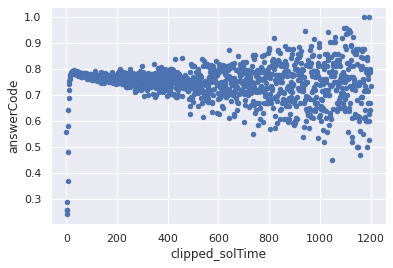

In [12]:
clipped_solTime_groupby.plot.scatter(x='clipped_solTime', y='answerCode')

## 문제 풀이에 사용한 총 시간 

In [13]:
df1['total_used_time'] = df1.groupby(['userID', 'testId'])['solTime'].cumsum()

## 시간대 & 요일

In [14]:
df1['hour'] = df1['Timestamp'].transform(lambda x: pd.to_datetime(x).dt.hour)
df1['weekday'] = df1['Timestamp'].transform(lambda x: pd.to_datetime(x).dt.weekday)

In [15]:
hour_groupby = df1.groupby('hour').agg({'answerCode': 'mean'})
hour_groupby.index.name = 'hour'
hour_groupby.reset_index(inplace=True)
hour_groupby

,hour,answerCode
0,0,0.650462
1,1,0.644876
2,2,0.642090
3,3,0.633329
4,4,0.633352
5,5,0.624684
6,6,0.628330
7,7,0.641452
8,8,0.669495
9,9,0.682831


<AxesSubplot:xlabel='hour'>

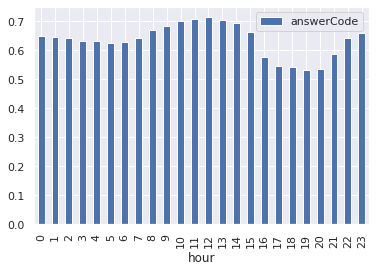

In [16]:
hour_groupby.plot.bar(x='hour', y='answerCode')

In [17]:
weekday_groupby = df1.groupby('weekday').agg({'answerCode': 'mean'})
weekday_groupby.index.name = 'weekday'
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_groupby['weekday_name'] = days
weekday_groupby.reset_index(inplace=True)
weekday_groupby.head(24)

,weekday,answerCode,weekday_name
0,0,0.675781,Mon
1,1,0.667045,Tue
2,2,0.641120,Wed
3,3,0.657922,Thu
4,4,0.643650,Fri
5,5,0.603369,Sat
6,6,0.674146,Sun


<AxesSubplot:xlabel='weekday_name'>

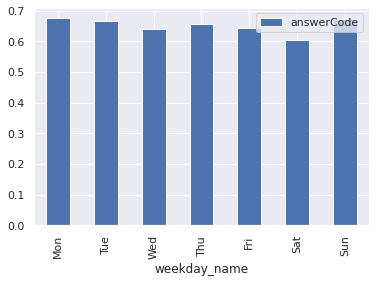

In [18]:
weekday_groupby.plot.bar(x='weekday_name', y='answerCode')

In [19]:
df1

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,isTest,clipped_solTime,total_used_time,hour,weekday
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,0,3,3,0,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,0,8,11,0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,0,7,18,0,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,0,7,25,0,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,0,11,36,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18,1,18,18,23,2
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21,1,21,39,23,2
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89,1,89,128,23,2
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32,1,32,160,23,2


# 정답률 

In [20]:
df2 = df1.copy()

## 문항별

In [21]:
# 특정 문항 과거에 푼 횟수
df2['past_prob_count'] = df2.groupby('assessmentItemID').cumcount()

# 특정 문항 과거에 맞춘 횟수
df2['shift'] = df2.groupby('assessmentItemID')['answerCode'].shift().fillna(0)
df2['past_prob_correct'] = df2.groupby('assessmentItemID')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 문항 과거 평균 정답률
df2['average_prob_correct'] = (df2['past_prob_correct'] / df2['past_prob_count']).fillna(0)

In [22]:
prob_groupby = df2.groupby('past_prob_count').agg({
    'answerCode': percentile
})
prob_groupby.index.name = 'past_prob_count'
prob_groupby.reset_index(inplace=True)
prob_groupby.describe()

,past_prob_count,answerCode
count,500.000000,500.000000
mean,249.500000,0.595830
std,144.481833,0.101548
min,0.000000,0.197917
25%,124.750000,0.527027
50%,249.500000,0.638824
75%,374.250000,0.667384
max,499.000000,0.712185


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_prob_count', ylabel='answerCode'>

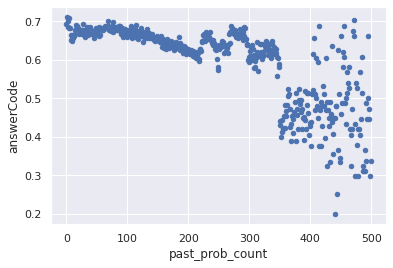

In [23]:
prob_groupby.plot.scatter(x='past_prob_count', y='answerCode')

## 태그별

In [24]:
# 특정 태그 과거에 푼 횟수
df2['past_tag_count'] = df2.groupby('KnowledgeTag').cumcount()

# 특정 태그 과거에 맞춘 횟수
df2['shift'] = df2.groupby('KnowledgeTag')['answerCode'].shift().fillna(0)
df2['past_tag_correct'] = df2.groupby('KnowledgeTag')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 태그 과거 평균 정답률
df2['average_tag_correct'] = (df2['past_tag_correct'] / df2['past_tag_count']).fillna(0)

In [25]:
tag_groupby = df2.groupby('past_tag_count').agg({
    'answerCode': percentile
})
tag_groupby.index.name = 'past_tag_count'
tag_groupby.reset_index(inplace=True)
tag_groupby.describe()

,past_tag_count,answerCode
count,14350.000000,14350.000000
mean,7174.500000,0.700970
std,4142.632516,0.210077
min,0.000000,0.000000
25%,3587.250000,0.626415
50%,7174.500000,0.666667
75%,10761.750000,0.800000
max,14349.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_tag_count', ylabel='answerCode'>

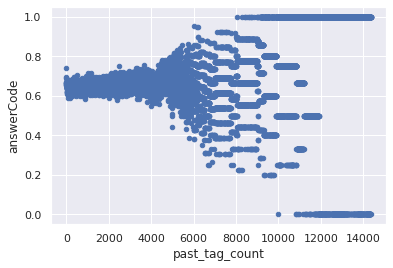

In [26]:
tag_groupby.plot.scatter(x='past_tag_count', y='answerCode')

## 사용자별

In [27]:
# 과거에 푼 문제 수
df2['past_user_count'] = df2.groupby('userID').cumcount()

# 과거에 맞춘 문제 수
df2['shift'] = df2.groupby('userID')['answerCode'].shift().fillna(0)
df2['past_user_correct'] = df2.groupby('userID')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 평균 정답률
df2['average_user_correct'] = (df2['past_user_correct'] / df2['past_user_count']).fillna(0)

In [28]:
user_groupby = df2.groupby('past_user_count').agg({
    'answerCode': percentile
})
user_groupby.index.name = 'past_user_count'
user_groupby.reset_index(inplace=True)
user_groupby.describe()

,past_user_count,answerCode
count,1860.000000,1860.000000
mean,929.500000,0.647544
std,537.080069,0.105707
min,0.000000,0.000000
25%,464.750000,0.642489
50%,929.500000,0.657800
75%,1394.250000,0.673501
max,1859.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_user_count', ylabel='answerCode'>

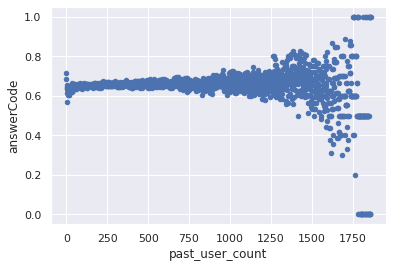

In [29]:
user_groupby.plot.scatter(x='past_user_count', y='answerCode')

## 사용자 + 태그별

In [30]:
# 과거에 해당 태그를 푼 수
df2['past_user_tag_count'] = df2.groupby(['userID', 'KnowledgeTag']).cumcount()

# 과거에 해당 태그를 맞춘 횟수
df2['shift'] = df2.groupby(['userID', 'KnowledgeTag'])['answerCode'].shift().fillna(0)
df2['past_user_tag_correct'] = df2.groupby(['userID', 'KnowledgeTag'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 태그 평균 정답률
df2['average_user_tag_correct'] = (df2['past_user_tag_correct'] / df2['past_user_tag_count']).fillna(0)

In [31]:
user_tag_groupby = df2.groupby('past_user_tag_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_tag_groupby.index.name = 'past_user_tag_count'
user_tag_groupby.reset_index(inplace=True)
user_tag_groupby

,past_user_tag_count,userID,answerCode
0,0,492354,0.687444
1,1,422906,0.669106
2,2,367129,0.650831
3,3,315447,0.643243
4,4,269447,0.599376
...,...,...,...
103,103,1,1.000000
104,104,1,1.000000
105,105,1,0.000000
106,106,1,0.000000


## 사용자 + 문항별

In [32]:
# 과거에 해당 문제를 푼 수
df2['past_user_content_count'] = df2.groupby(['userID', 'assessmentItemID']).cumcount()

# 과거에 해당 문제를 맞춘 횟수
df2['shift'] = df2.groupby(['userID', 'assessmentItemID'])['answerCode'].shift().fillna(0)
df2['past_user_content_correct'] = df2.groupby(['userID', 'assessmentItemID'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 문제 평균 정답률
df2['average_user_content_correct'] = (df2['past_user_content_correct'] / df2['past_user_content_count']).fillna(0)

In [33]:
user_content_groupby = df2.groupby('past_user_content_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_content_groupby.index.name = 'past_user_content_count'
user_content_groupby.reset_index(inplace=True)
user_content_groupby

,past_user_content_count,userID,answerCode
0,0,2476706,0.654363
1,1,49100,0.647088
2,2,894,0.454139


<AxesSubplot:ylabel='userID'>

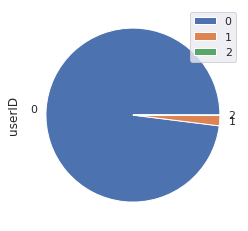

In [34]:
user_content_groupby.plot.pie(x='past_user_content_count', y='userID')

In [35]:
df2.dtypes

userID                                   int16
assessmentItemID                        object
testId                                  object
answerCode                                int8
Timestamp                       datetime64[ns]
KnowledgeTag                             int16
Category                                object
Number                                  object
Time                                     int64
solTime                                  int64
isTest                                   int64
clipped_solTime                          int64
total_used_time                          int64
hour                                     int64
weekday                                  int64
past_prob_count                          int64
past_prob_correct                      float64
average_prob_correct                   float64
past_tag_count                           int64
past_tag_correct                       float64
average_tag_correct                    float64
past_user_cou

In [36]:
df2

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,average_tag_correct,past_user_count,past_user_correct,average_user_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct,past_user_content_count,past_user_content_correct,average_user_content_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,...,0.000000,0,0.0,0.000000,0,0.0,0.0,0,0.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,...,0.000000,1,1.0,1.000000,0,0.0,0.0,0,0.0,0.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,...,1.000000,2,2.0,1.000000,1,1.0,1.0,0,0.0,0.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,...,1.000000,3,3.0,1.000000,2,2.0,1.0,0,0.0,0.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,...,1.000000,4,4.0,1.000000,3,3.0,1.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18,...,0.638487,11,8.0,0.727273,0,0.0,0.0,0,0.0,0.0
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21,...,0.638251,12,8.0,0.666667,1,0.0,0.0,0,0.0,0.0
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89,...,0.762104,13,9.0,0.692308,0,0.0,0.0,0,0.0,0.0
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32,...,0.762302,14,10.0,0.714286,1,1.0,1.0,0,0.0,0.0


In [37]:
df = df2
df_train = df[df['isTest'] == 0]
df_test = df[df['isTest'] == 1]

In [38]:
df_train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,average_tag_correct,past_user_count,past_user_correct,average_user_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct,past_user_content_count,past_user_content_correct,average_user_content_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,...,0.000000,0,0.0,0.000000,0,0.0,0.00,0,0.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,...,0.000000,1,1.0,1.000000,0,0.0,0.00,0,0.0,0.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,...,1.000000,2,2.0,1.000000,1,1.0,1.00,0,0.0,0.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,...,1.000000,3,3.0,1.000000,2,2.0,1.00,0,0.0,0.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,...,1.000000,4,4.0,1.000000,3,3.0,1.00,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3,A071005,1591339821,0,...,0.689875,4,1.0,0.250000,4,1.0,0.25,0,0.0,0.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4,A165001,1597971999,11,...,0.697490,5,1.0,0.200000,0,0.0,0.00,0,0.0,0.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4,A165002,1597972010,46,...,0.697586,6,2.0,0.333333,1,1.0,1.00,0,0.0,0.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4,A165003,1597972056,73,...,0.697682,7,3.0,0.428571,2,2.0,1.00,0,0.0,0.0


In [39]:
df_test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,average_tag_correct,past_user_count,past_user_correct,average_user_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct,past_user_content_count,past_user_content_correct,average_user_content_correct
2266586,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,5,A023001,1578567391,26,...,0.641379,0,0.0,0.000000,0,0.0,0.0,0,0.0,0.0
2266587,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,5,A023002,1578567417,94,...,0.641604,1,1.0,1.000000,1,1.0,1.0,0,0.0,0.0
2266588,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5,A023003,1578567511,5,...,0.670013,2,2.0,1.000000,0,0.0,0.0,0,0.0,0.0
2266589,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,5,A023004,1578567516,7,...,0.669721,3,2.0,0.666667,1,0.0,0.0,0,0.0,0.0
2266590,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,5,A023006,1578567523,3,...,0.568970,4,2.0,0.500000,0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18,...,0.638487,11,8.0,0.727273,0,0.0,0.0,0,0.0,0.0
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21,...,0.638251,12,8.0,0.666667,1,0.0,0.0,0,0.0,0.0
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89,...,0.762104,13,9.0,0.692308,0,0.0,0.0,0,0.0,0.0
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32,...,0.762302,14,10.0,0.714286,1,1.0,1.0,0,0.0,0.0


In [40]:
df_train.to_csv("/opt/ml/input/data/train_dataset/tuning_train_data_2.csv", mode='w')
df_test.to_csv("/opt/ml/input/data/train_dataset/tuning_test_data_2.csv", mode='w')

# Feature Selection

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

df = pd.read_csv('/opt/ml/input/data/train_dataset/tuning_train_data_2.csv', index_col = 0)
df.head()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,average_tag_correct,past_user_count,past_user_correct,average_user_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct,past_user_content_count,past_user_content_correct,average_user_content_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,...,0.0,1,1.0,1.0,0,0.0,0.0,0,0.0,0.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,...,1.0,2,2.0,1.0,1,1.0,1.0,0,0.0,0.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,...,1.0,3,3.0,1.0,2,2.0,1.0,0,0.0,0.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,...,1.0,4,4.0,1.0,3,3.0,1.0,0,0.0,0.0


## OLS

In [82]:
df['intercept'] = 1
df_new = df[df.columns.difference(['assessmentItemID', 'testId', 'Timestamp', 'Number', 'isTest'])]
lm = sm.OLS(df['answerCode'], df_new)
results = lm.fit()
s = results.summary()

In [83]:
s

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             answerCode   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.401e+24
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:17:38   Log-Likelihood:             4.8542e+07
No. Observations:             2266586   AIC:                        -9.708e+07
Df Residuals:                 2266560   BIC:                        -9.708e+07
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Category                     -4.502e-12   4.62e-14    -97.345      0.000   -4.59e-12   -4.41e-12
KnowledgeTag                 -6.964e-16   2.53e-17    -27.577      0.000   -7.46e-16   -6.47e-16
Time                         -4.466e-20   1.55e-20     -2.876      0.004   -7.51e-20   -1.42e-20
answerCode                       1.0000   1.95e-13   5.14e+12      0.000       1.000       1.000
average_prob_correct         -1.362e-12   7.53e-13     -1.809      0.070   -2.84e-12    1.14e-13
average_tag_correct          -2.846e-12   1.13e-12     -2.517      0.012   -5.06e-12    -6.3e-13
average_user_content_correct -1.436e-13      6e-12     -0.024      0.981   -1.19e-11    1.16e-11
average_user_correct         -8.688e-13   6.13e-13     -1.416      0.157   -2.07e-12    3.33e-13
average_user_tag_correct     -2.906e-12    2.5e-13    -11.624      0.000    -3.4e-12   -2.42e-12
clipped_solTime              -2.005e-14   5.93e-16    -33.798      0.000   -2.12e-14   -1.89e-14
hour                          1.647e-11   1.36e-14   1213.956      0.000    1.64e-11    1.65e-11
intercept                    -8.087e-13   2.47e-11     -0.033      0.974   -4.91e-11    4.75e-11
past_prob_correct            -2.621e-13   5.16e-15    -50.786      0.000   -2.72e-13   -2.52e-13
past_prob_count              -1.152e-13   3.54e-15    -32.555      0.000   -1.22e-13   -1.08e-13
past_tag_correct              6.603e-15   4.33e-16     15.263      0.000    5.75e-15    7.45e-15
past_tag_count                2.149e-14   3.06e-16     70.203      0.000    2.09e-14    2.21e-14
past_user_content_correct     1.741e-13   6.01e-12      0.029      0.977   -1.16e-11     1.2e-11
past_user_content_count      -1.013e-14   9.96e-13     -0.010      0.992   -1.96e-12    1.94e-12
past_user_correct             6.912e-14   1.73e-15     39.859      0.000    6.57e-14    7.25e-14
past_user_count               1.223e-14   1.28e-15      9.527      0.000    9.72e-15    1.48e-14
past_user_tag_correct        -1.291e-11   7.22e-14   -178.796      0.000   -1.31e-11   -1.28e-11
past_user_tag_count          -1.048e-11   5.27e-14   -198.860      0.000   -1.06e-11   -1.04e-11
solTime                      -4.242e-17   1.17e-17     -3.627      0.000   -6.53e-17   -1.95e-17
total_used_time               2.893e-16   3.99e-18     72.583      0.000    2.82e-16    2.97e-16
userID                       -6.647e-15   1.04e-16    -63.833      0.000   -6.85e-15   -6.44e-15
weekday                       9.099e-12   4.75e-14    191.734      0.000    9.01e-12    9.19e-12
==============================================================================
Omnibus:                    98423.626   Durbin-Watson:                   0.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           335333.149
Skew:                          -0

In [84]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             answerCode   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.401e+24
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:17:38   Log-Likelihood:             4.8542e+07
No. Observations:             2266586   AIC:                        -9.708e+07
Df Residuals:                 2266560   BIC:                        -9.708e+07
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Category                     -4.502e-12   4.62e-14    -97.345      0.000   -4.59e-12   -4.41e-12
KnowledgeTag                 -6.964e-16   2.53e-17    -27.577      0.000   -7.46e-16   -6.47e-16
Time                         -4.466e-20   1.55e-20     -2.876      0.004   -7.51e-20   -1.42e-20
answerCode                       1.0000   1.95e-13   5.14e+12      0.000       1.000       1.000
average_prob_correct         -1.362e-12   7.53e-13     -1.809      0.070   -2.84e-12    1.14e-13
average_tag_correct          -2.846e-12   1.13e-12     -2.517      0.012   -5.06e-12    -6.3e-13
average_user_content_correct -1.436e-13      6e-12     -0.024      0.981   -1.19e-11    1.16e-11
average_user_correct         -8.688e-13   6.13e-13     -1.416      0.157   -2.07e-12    3.33e-13
average_user_tag_correct     -2.906e-12    2.5e-13    -11.624      0.000    -3.4e-12   -2.42e-12
clipped_solTime              -2.005e-14   5.93e-16    -33.798      0.000   -2.12e-14   -1.89e-14
hour                          1.647e-11   1.36e-14   1213.956      0.000    1.64e-11    1.65e-11
intercept                    -8.087e-13   2.47e-11     -0.033      0.974   -4.91e-11    4.75e-11
past_prob_correct            -2.621e-13   5.16e-15    -50.786      0.000   -2.72e-13   -2.52e-13
past_prob_count              -1.152e-13   3.54e-15    -32.555      0.000   -1.22e-13   -1.08e-13
past_tag_correct              6.603e-15   4.33e-16     15.263      0.000    5.75e-15    7.45e-15
past_tag_count                2.149e-14   3.06e-16     70.203      0.000    2.09e-14    2.21e-14
past_user_content_correct     1.741e-13   6.01e-12      0.029      0.977   -1.16e-11     1.2e-11
past_user_content_count      -1.013e-14   9.96e-13     -0.010      0.992   -1.96e-12    1.94e-12
past_user_correct             6.912e-14   1.73e-15     39.859      0.000    6.57e-14    7.25e-14
past_user_count               1.223e-14   1.28e-15      9.527      0.000    9.72e-15    1.48e-14
past_user_tag_correct        -1.291e-11   7.22e-14   -178.796      0.000   -1.31e-11   -1.28e-11
past_user_tag_count          -1.048e-11   5.27e-14   -198.860      0.000   -1.06e-11   -1.04e-11
solTime                      -4.242e-17   1.17e-17     -3.627      0.000   -6.53e-17   -1.95e-17
total_used_time               2.893e-16   3.99e-18     72.583      0.000    2.82e-16    2.97e-16
userID                       -6.647e-15   1.04e-16    -63.833      0.000   -6.85e-15   -6.44e-15
weekday                       9.099e-12   4.75e-14    191.734      0.000    9.01e-12    9.19e-12
==============================================================================
Omnibus:                    98423.626   Durbin-Watson:                   0.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           335333.149
Skew:                          -0

## Feature Importance

In [85]:
df = df.drop(['assessmentItemID', 'testId', 'Timestamp', 'Number', 'isTest'],axis=1)

In [86]:
X_train, y_train = df.loc[:,df.columns!='answerCode'], df['answerCode']

In [87]:
X_train

,userID,KnowledgeTag,Category,Time,solTime,clipped_solTime,total_used_time,hour,weekday,past_prob_count,...,past_user_count,past_user_correct,average_user_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct,past_user_content_count,past_user_content_correct,average_user_content_correct,intercept
0,0,7224,6,1585009031,3,3,3,0,1,0,...,0,0.0,0.000000,0,0.0,0.00,0,0.0,0.0,1
1,0,7225,6,1585009034,8,8,11,0,1,0,...,1,1.0,1.000000,0,0.0,0.00,0,0.0,0.0,1
2,0,7225,6,1585009042,7,7,18,0,1,0,...,2,2.0,1.000000,1,1.0,1.00,0,0.0,0.0,1
3,0,7225,6,1585009049,7,7,25,0,1,0,...,3,3.0,1.000000,2,2.0,1.00,0,0.0,0.0,1
4,0,7225,6,1585009056,11,11,36,0,1,0,...,4,4.0,1.000000,3,3.0,1.00,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,438,3,1591339821,0,0,220,6,4,277,...,4,1.0,0.250000,4,1.0,0.25,0,0.0,0.0,1
2266582,7441,8836,4,1597971999,11,11,11,1,4,273,...,5,1.0,0.200000,0,0.0,0.00,0,0.0,0.0,1
2266583,7441,8836,4,1597972010,46,46,57,1,4,273,...,6,2.0,0.333333,1,1.0,1.00,0,0.0,0.0,1
2266584,7441,8836,4,1597972056,73,73,130,1,4,273,...,7,3.0,0.428571,2,2.0,1.00,0,0.0,0.0,1


In [88]:
y_train

0          1
1          1
2          1
3          1
4          1
          ..
2266581    0
2266582    1
2266583    1
2266584    1
2266585    1
Name: answerCode, Length: 2266586, dtype: int64

In [89]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42) # n_estimators: 사용할 tree수
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42)

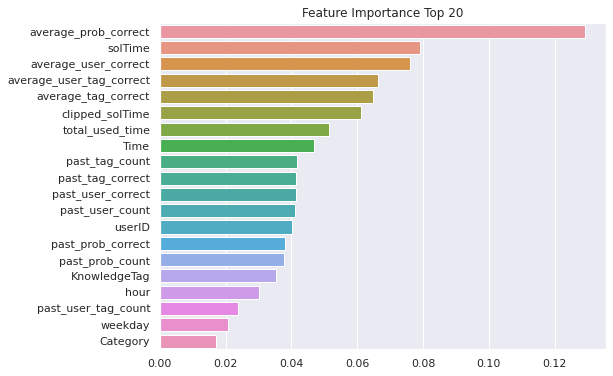

In [90]:
# 배열형태로 반환
ft_importance_values = forest.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()